In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
dates = pd.date_range(start="2025-01-01", end="2025-07-01", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2025-06-01"
returns[mask_pre_may] -= 0.0015

# Inject "shock" values
shock_values = {
    "2025-06-02": 0.1748425237194541,
    "2025-06-03": -0.16825801732486943,
    "2025-06-06": -0.19667220757153227,
    "2025-06-09": 0.21240223590614747,
    "2025-06-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.3 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

In [15]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

In [16]:
df

,date,daily_return,daily_return_2
0,2025-01-01,0.001263,-0.002977
1,2025-01-02,-0.020046,-0.007600
2,2025-01-03,0.004739,-0.001705
3,2025-01-06,0.009953,-0.002302
4,2025-01-07,0.008872,0.007942
...,...,...,...
125,2025-06-25,0.000326,-0.004915
126,2025-06-26,0.025253,0.007917
127,2025-06-27,-0.001749,-0.010998
128,2025-06-30,-0.008420,-0.001506


In [17]:
target_col = df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()

outlier_iqr    0.061538
outlier_z      0.038462
dtype: float64

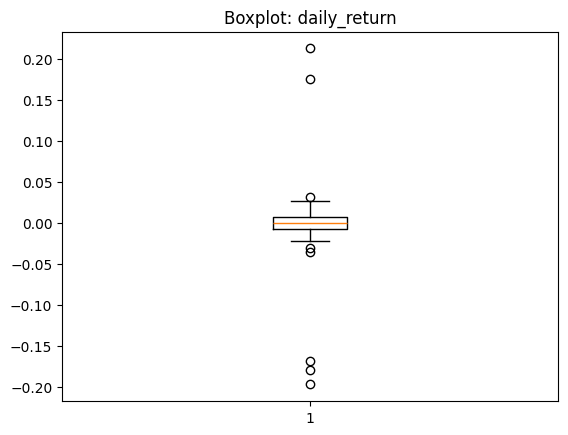

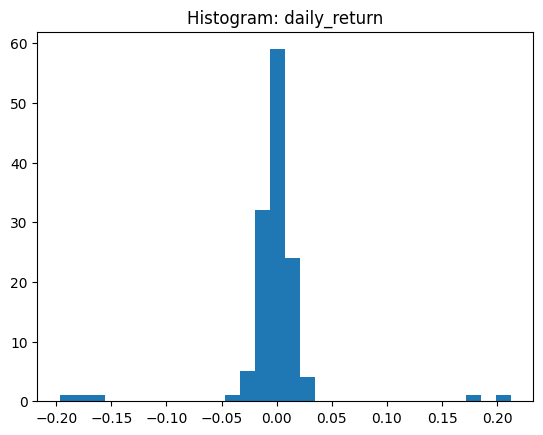

In [18]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

In [19]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,-0.001136,0.000355,-0.000094
median,-0.000100,0.000043,-0.000100
std,0.038346,0.009944,0.010613
